#### Imports

In [31]:
import sys
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.ndimage as ndimage
# Ensure gaussian_filter1d is available as an attribute on scipy.signal for compatibility
signal.gaussian_filter1d = ndimage.gaussian_filter1d
from IPython.display import display
from scipy.optimize import curve_fit

# Now import the local functions (after we patched scipy.signal)
from photocurrent_functions import *

# Provide convenient local names used in the notebook
find_peaks = signal.find_peaks
gaussian_filter1d = ndimage.gaussian_filter1d


#### Paths

In [32]:
folder_path = r'/Users/vitoralmeida/Library/CloudStorage/OneDrive-Personal/DOUTORADO/Python/Py_elchem/data/photocurrent'

# Define the path to the folder you want to create
saving_path = r'/Users/vitoralmeida/Library/CloudStorage/OneDrive-Personal/DOUTORADO/Python/Py_elchem/results/Photocurrent_results'

# # Create the directory. If it already exists, nothing happens.
os.makedirs(saving_path, exist_ok=True)

print(f"Folder '{saving_path}' is ready")

Folder '/Users/vitoralmeida/Library/CloudStorage/OneDrive-Personal/DOUTORADO/Python/Py_elchem/results/Photocurrent_results' is ready


#### Load pre process

In [3]:
desired_potentials = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
tables = load_dta_folder(folder_path,verbose=False)
data_by_potential = group_by_potential(tables, desired_potentials=desired_potentials,verbose=False)

In [4]:
print(tables.keys())

dict_keys(['Photocurrent_MA', 'Photocurrent_MB', 'Photocurrent_MC', 'Photocurrent_MD', 'Photocurrent_ME'])


#### Plots

Starting analysis for 0.6V...


Processing: MA


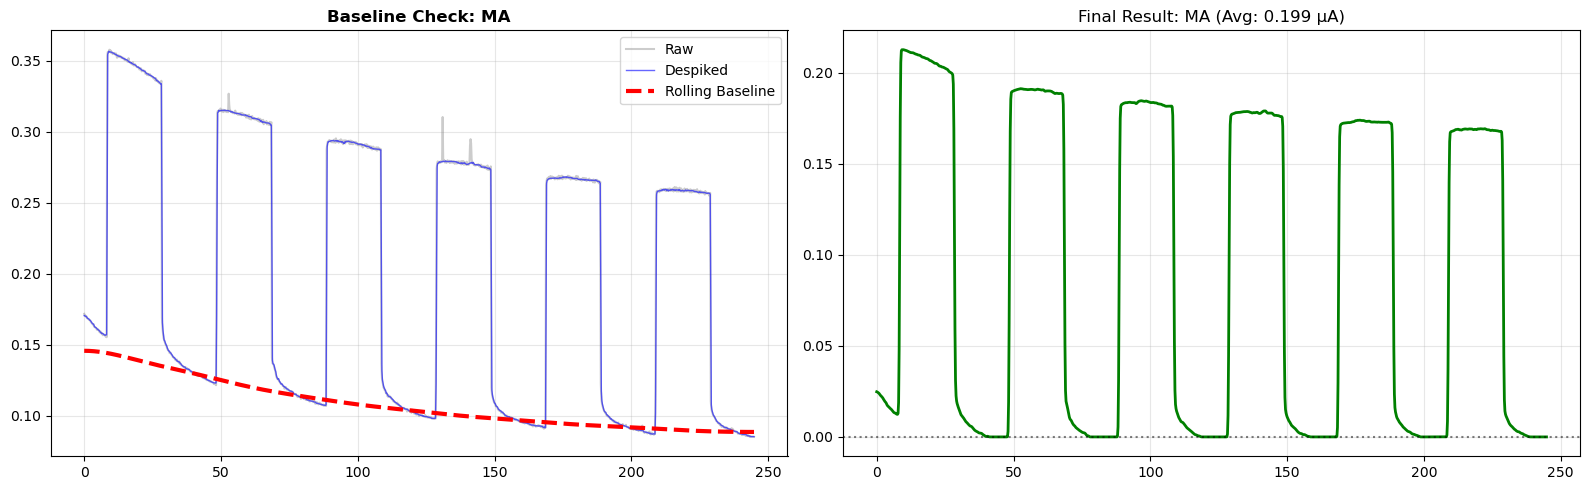


Processing: MB


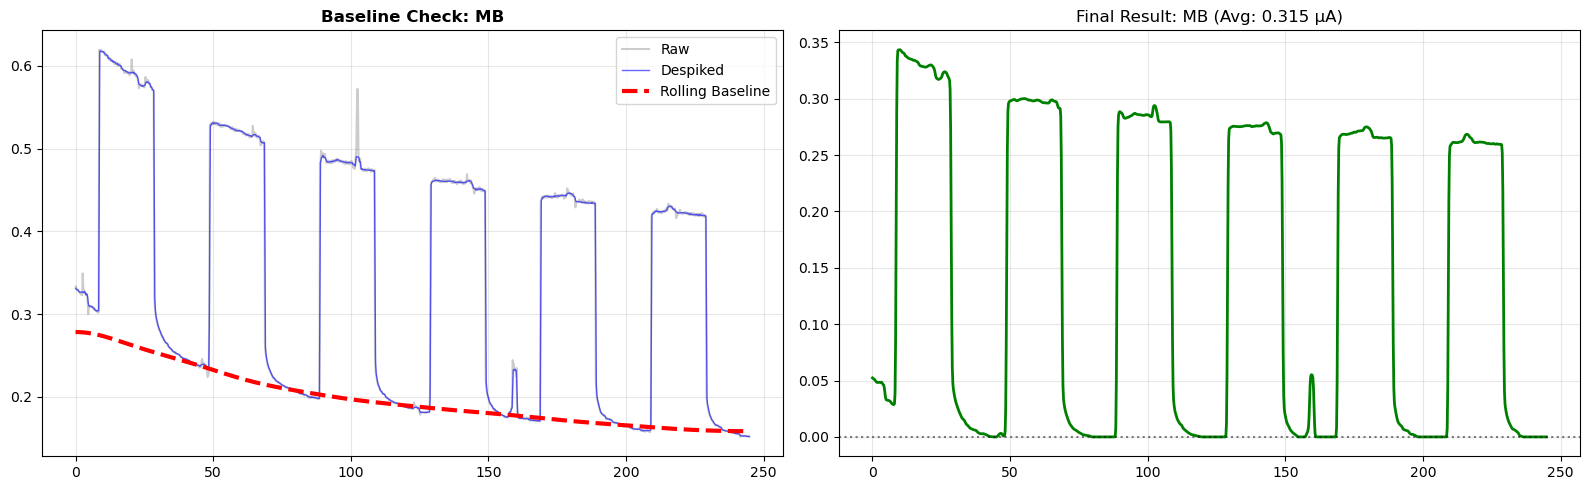


Processing: MC


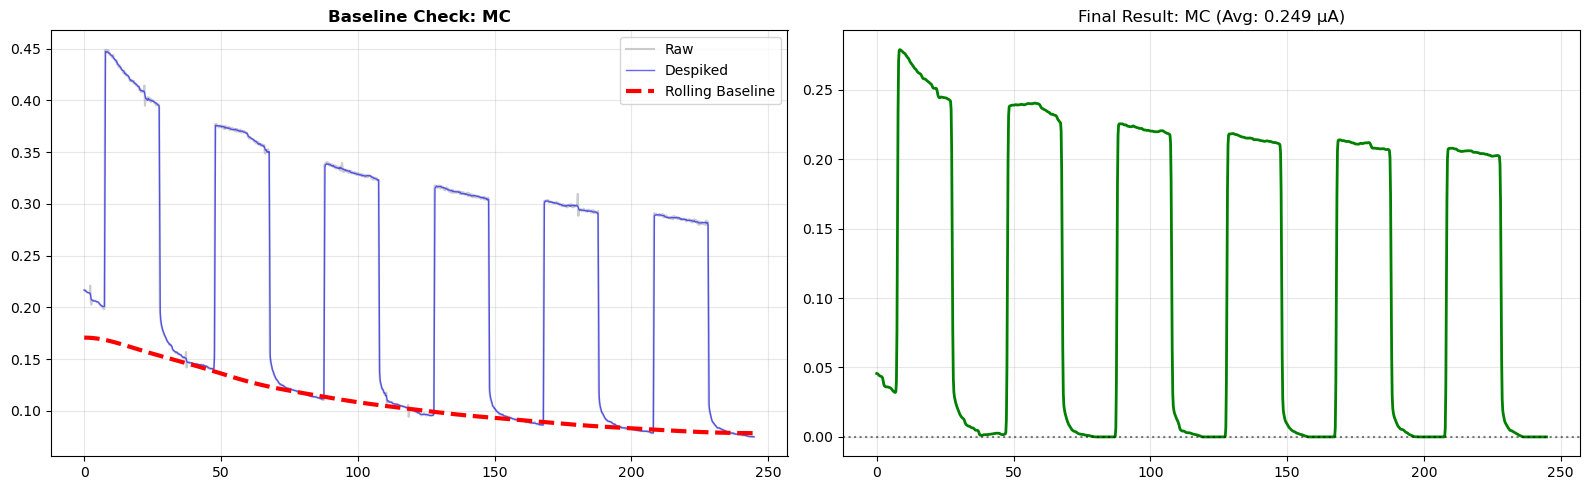


Processing: MD


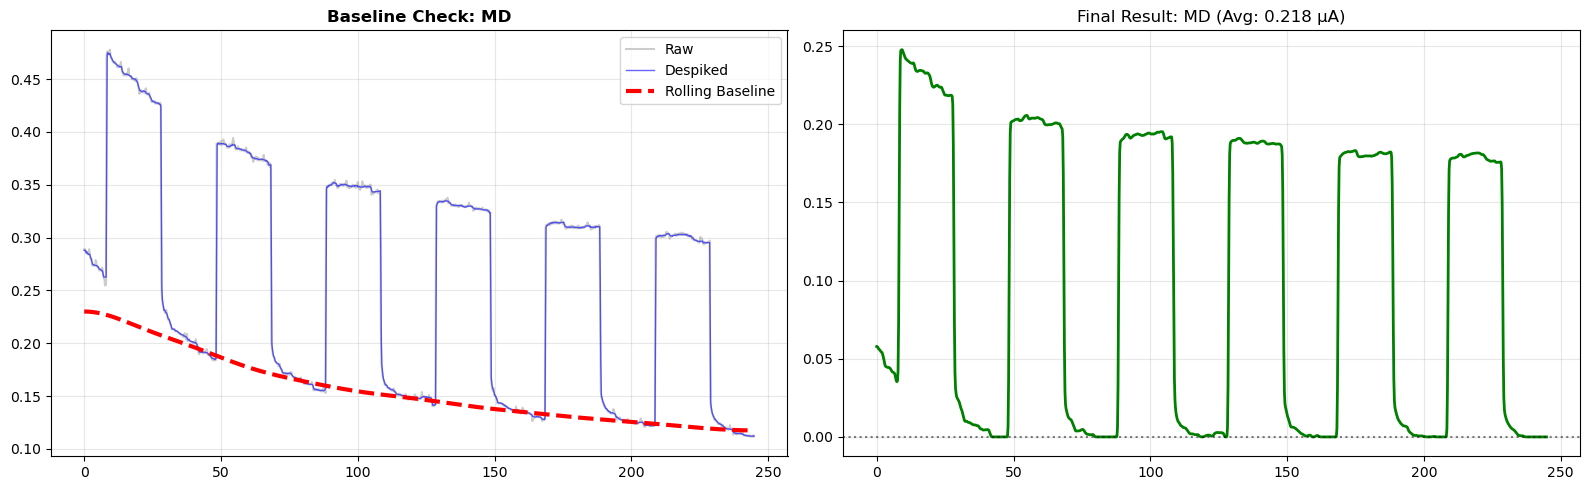


Processing: ME


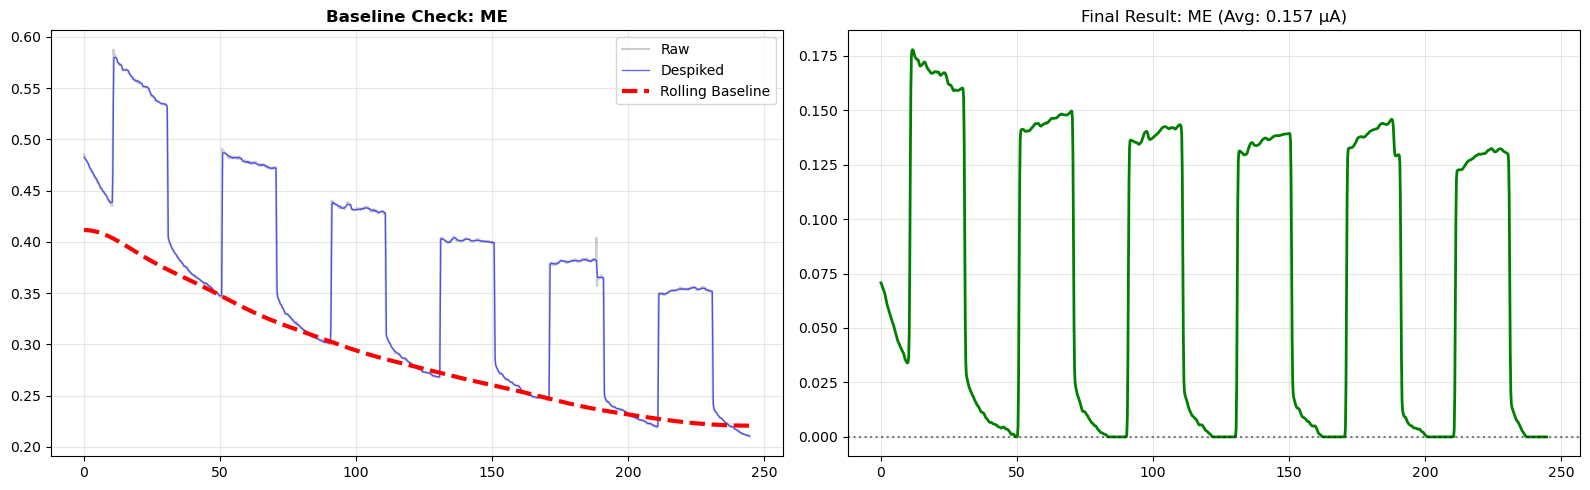

Processing complete. 'final_results_df' created successfully.


,Time_s,MA,MB,MC,MD,ME
0,0.0,0.024784,0.052334,0.045709,0.057855,0.070684
1,0.2,0.024667,0.051924,0.045577,0.057750,0.070166
2,0.4,0.024437,0.051466,0.045313,0.057379,0.069480
3,0.6,0.024216,0.051163,0.044914,0.056632,0.068864
4,0.8,0.023970,0.050780,0.044474,0.056077,0.068255


,Avg_Photocurrent_uA
MA,0.198953
MB,0.314734
MC,0.248720
MD,0.217520
ME,0.156810


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display  # <--- FIX: Explicitly import the correct display function

# === 1. CONFIGURATION ===
experiments_to_plot = {
    'Photocurrent_MA': 'MA',
    'Photocurrent_MB': 'MB',
    'Photocurrent_MC': 'MC',
    'Photocurrent_MD': 'MD',
    'Photocurrent_ME': 'ME',
}
potential_to_plot = '0.6V'
start_time_s = 35

# === 2. EXECUTION LOOP ===
final_data_for_overlay = {}
summary_data = {}
dfs_to_combine = [] # List to hold data for final combination

print(f"Starting analysis for {potential_to_plot}...\n")

for experiment_name, clean_label in experiments_to_plot.items():
    print(f"\n{'='*40}\nProcessing: {clean_label}\n{'='*40}")

    # -- A) Get Data --
    try:
        original_df = data_by_potential[experiment_name][potential_to_plot]
    except KeyError:
        print(f"⚠️ Warning: No data for {clean_label}. Skipping.")
        continue

    # -- B) Process --
    df_processed, avg_photocurrent = process_photocurrent_robust(
        original_df,
        start_time_s=start_time_s,
        # --- BASELINE PARAMETERS ---
        use_rolling_baseline=True,
        baseline_window_s=60.0,
        baseline_quantile=0.20,
        baseline_smoothing_sigma=15.0,
        # --- OTHER PARAMETERS ---
        hampel_window_s=2.0,
        hampel_nsigmas=0.5,
        smoothing_sigma=1.0,
        light_on_quantile=0.85
    )

    if df_processed is None:
        print(f"❌ Error processing {clean_label}")
        continue

    # -- C) Store Results --
    summary_data[clean_label] = avg_photocurrent
    final_data_for_overlay[experiment_name] = df_processed

    # Prepare for final combination immediately
    df_subset = df_processed[['Time_s', 'Photocurrent_uA']].copy()
    df_subset.columns = ['Time_s', clean_label]
    dfs_to_combine.append(df_subset.set_index('Time_s'))

    # -- D) DIAGNOSTIC PLOTS --
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Left Plot: Baseline Check
    ax[0].plot(df_processed['Time_s'], df_processed['Current_uA_raw'],
               color='gray', alpha=0.4, label='Raw')
    ax[0].plot(df_processed['Time_s'], df_processed['Current_uA_despiked'],
               color='blue', lw=1, alpha=0.6, label='Despiked')
    ax[0].plot(df_processed['Time_s'], df_processed['Baseline'],
               color='red', lw=3, linestyle='--', label='Rolling Baseline')
    ax[0].set_title(f"Baseline Check: {clean_label}", fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Right Plot: Final Result
    ax[1].plot(df_processed['Time_s'], df_processed['Photocurrent_uA'],
               color='green', lw=2, label='Net Photocurrent')
    ax[1].axhline(0, color='k', ls=':', alpha=0.5)
    ax[1].set_title(f"Final Result: {clean_label} (Avg: {avg_photocurrent:.3f} µA)")
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# === 3. FINAL COMBINATION ===
if dfs_to_combine:
    final_results_df = pd.concat(dfs_to_combine, axis=1, join='outer')
    final_results_df = final_results_df.sort_index().reset_index()
    print("Processing complete. 'final_results_df' created successfully.")
    # Use the explicitly imported display function
    display(final_results_df.head())

    display(pd.DataFrame.from_dict(summary_data, orient='index', columns=['Avg_Photocurrent_uA']))
else:
    print("Error: No data was processed successfully.")

In [33]:
# === 1. CONFIGURATION ===
experiments_to_plot = {
    'Photocurrent_MA': 'MA',
    'Photocurrent_MB': 'MB',
    'Photocurrent_MC': 'MC',
    'Photocurrent_MD': 'MD',
    'Photocurrent_ME': 'ME',
}
potential_to_plot = '0.6V'
start_time_s = 35

# === 2. EXECUTION LOOP ===
final_data_for_overlay = {}
summary_data = {}
dfs_to_combine = []

print(f"Starting analysis for {potential_to_plot}...\n")

for experiment_name, clean_label in experiments_to_plot.items():
    print(f"\n{'='*40}\nProcessing: {clean_label}\n{'='*40}")

    try:
        original_df = data_by_potential[experiment_name][potential_to_plot]
    except KeyError:
        print(f"⚠️ Warning: No data for {clean_label}. Skipping.")
        continue

    # -- CALL UPDATED FUNCTION --
    df_processed, avg_photocurrent = process_photocurrent_robust(
        original_df,
        start_time_s=start_time_s,
        use_rolling_baseline=True,
        baseline_window_s=60.0,
        baseline_quantile=0.10,
        baseline_smoothing_sigma=8.0,
        hampel_window_s=2.0,
        hampel_nsigmas=4.0,
        smoothing_sigma=1.0,
        # --- Trimmed Mean Range ---
        # (0.70, 0.95) means: Ignore top 5% (spikes) AND bottom 70% (baseline)
        plateau_range=(0.70, 0.95)
    )

    if df_processed is None:
        print(f" Error processing {clean_label}")
        continue

    summary_data[clean_label] = avg_photocurrent
    final_data_for_overlay[experiment_name] = df_processed

    df_subset = df_processed[['Time_s', 'Photocurrent_uA']].copy()
    df_subset.columns = ['Time_s', clean_label]
    dfs_to_combine.append(df_subset.set_index('Time_s'))

    # -- PLOT --
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(df_processed['Time_s'], df_processed['Current_uA_raw'], color='gray', alpha=0.4, label='Raw')
    ax[0].plot(df_processed['Time_s'], df_processed['Baseline'], color='red', lw=3, ls='--', label='Rolling Baseline')
    ax[0].set_title(f"Baseline Check: {clean_label}", fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(df_processed['Time_s'], df_processed['Photocurrent_uA'], color='green', lw=2, label='Net Photocurrent')
    # Show the computed average as a horizontal line to verify it ignores outliers
    ax[1].axhline(avg_photocurrent, color='magenta', lw=2, ls='-', label=f'Avg (Trimmed): {avg_photocurrent:.3f}')
    ax[1].set_title(f"Final Result: {clean_label}")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === 3. FINAL RESULTS ===
if dfs_to_combine:
    final_results_df = pd.concat(dfs_to_combine, axis=1, join='outer').sort_index().reset_index()
    print("\n📊 Robust Averages (Top 5% excluded):\n", pd.Series(summary_data))

Starting analysis for 0.6V...


Processing: MA


TypeError: process_photocurrent_robust() got an unexpected keyword argument 'plateau_range'

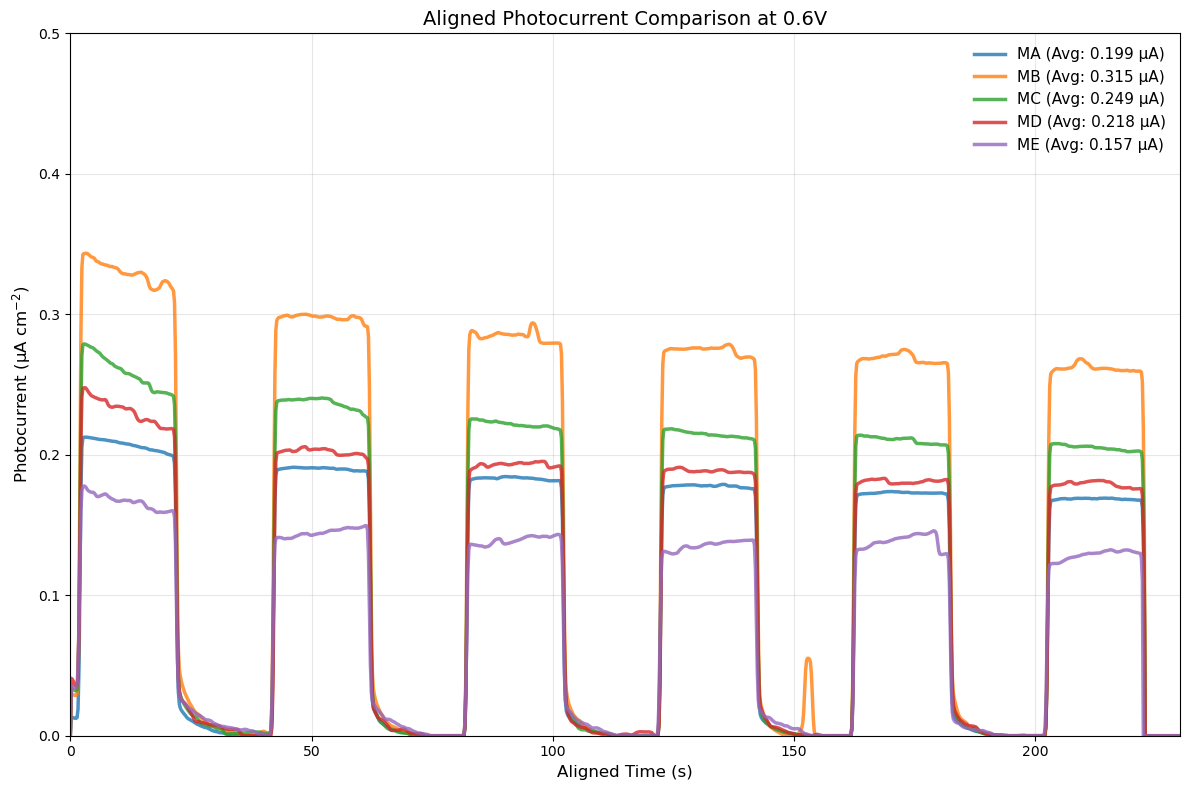

In [27]:
plt.figure(figsize=(12, 8))
ax = plt.gca()

aligned_data = {}

# Loop through the labels that exist in our final results
for clean_label in experiments_to_plot.values():
    if clean_label not in final_results_df.columns:
        continue

    # 1. Align this specific trace
    df_aligned = align_window_and_pad(
        final_results_df.dropna(subset=[clean_label]),
        time_col="Time_s",
        y_col=clean_label,
        baseline_window_s=5.0,
        threshold_frac=0.20,
        hold_s=0.30,
        prepad_s=2.0,
        pad_to_xmax=165.0
    )
    aligned_data[clean_label] = df_aligned

    # 2. Retrieve average and create a robust label
    avg_val = summary_data.get(clean_label, np.nan)

    # --- FIX: Check for nan BEFORE formatting ---
    if pd.isna(avg_val):
        label_text = f"{clean_label} (Avg: ---)"
    else:
        label_text = f"{clean_label} (Avg: {avg_val:.3f} µA)"
    # --- END FIX ---

    # 3. Plot with the new label
    ax.plot(df_aligned["Time_s"], df_aligned[clean_label],
            label=label_text, linewidth=2.5, alpha=0.8)

# --- Styling ---
ax.set_title(f"Aligned Photocurrent Comparison at {potential_to_plot}", fontsize=14)
ax.set_xlabel("Aligned Time (s)", fontsize=12)
ax.set_ylabel("Photocurrent (µA cm$^{-2}$)", fontsize=12)
ax.set_xlim(0, 230)
ax.set_ylim(0, 0.5)
# ax.axvline(x=2.0, color='k', ls=':', alpha=0.3, label='Trigger Onset')

ax.legend(loc="upper right", frameon=False, fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()